### Libraries

In [13]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

#Lema
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

#nlp count
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

### Load Data

In [14]:
df = pd.read_csv('src/data/entities.csv')

In [15]:
df.shape

(590, 11)

In [16]:
df.sample(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
195,Four things to know about China’s new AI rules...,https://www.technologyreview.com/2024/01/17/10...,2024,Four things to know about China’s new AI rules...,['the Stanford University Center for Internati...,2,#0000ff,386.0,629.0,p_28,thing know china new rule thing know china new...
280,Optimizing platforms offers customers and stak...,https://www.technologyreview.com/2023/09/27/10...,2023,Sponsored\nOptimizing platforms offers custome...,"['Ms.', 'Insights', ""JPMorgan Chase's"", 'the B...",1,#5500aa,601.0,462.0,p_20,optimize platform offer customer stakeholder w...
89,The Download: fighting blackouts with battery-...,https://www.technologyreview.com/2024/06/11/10...,2024,The Download: fighting blackouts with battery-...,"['Mount Sinai', 'US', 'Knowable Magazine', 'El...",2,#0000ff,256.0,629.0,p_31,download fight blackout battery swap network s...


### Clean Data

In [17]:
df.columns

Index(['title', 'url', 'year', 'text', 'entities', 'temperature', 'color', 'x',
       'y', 'cluster', 'clean_text'],
      dtype='object')

### Lematization

In [18]:

nlp = spacy.load("en_core_web_lg")

In [19]:
df['text_clean'] = df['title'] + ' ' + df['text'] 

In [20]:
df.text[1]

'What impact will AI have on video game development?\nIt could make working conditions more bearable—or it could just put people out of work.\nThis story is from The Algorithm, our weekly newsletter on AI. To get it in your inbox first, sign up here.\nVideo game development has long been plagued by fear of the “crunch”—essentially, being forced to work overtime on a game to meet a deadline. In the early days of video games, the crunch was often viewed as a rite of passage: In the last days before release, an obsessed group of scrappy developers would work late into the night to perfect their dream game.\nHowever, nowadays the crunch is less likely to be glamorized than to be seen as a form of exploitation that risks causing mental illness and burnout. Part of the issue is that crunch time used to be just before a game launched, but now whole game development periods are “crunchy.” With games getting more expensive, companies are incentivized to make even more short-term profits by sque

In [21]:
words={'ai'}
# Función para limpiar el texto
def clean_text(text):
    # Procesar el texto con spaCy
    doc = nlp(text)
    
    # Lematizar y filtrar stopwords, puntuación y palabras personalizadas
    tokens = [token.lemma_.lower() for token in doc 
              if token.text.lower() not in STOP_WORDS  # Eliminar stopwords
              and token.is_alpha  # Mantener solo caracteres alfabéticos
              and token.text.lower() not in string.punctuation  # Eliminar puntuación
              and token.text.lower() not in words]  # Eliminar palabras específicas
    
    # Unir los tokens limpios en un solo string
    return ' '.join(tokens)

In [22]:
# Aplicar la función de limpieza a la columna 'text'
df['clean_text'] = df['text_clean'].apply(clean_text)

In [23]:
df = df.drop('text_clean', axis=1)

In [24]:
df.head()

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,141.0,522.0,p_16,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,495.0,334.0,p_19,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,616.0,861.0,p_0,useful robot need lazy useful robot need lazy ...
3,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,"['Marcus Holmström', 'The Gang', 'AI', 'France...",2,#0000ff,497.0,337.0,p_19,roblox launch generative build environment sna...
4,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,"['TEE', 'Microsoft Security', 'Insights', 'the...",2,#0000ff,632.0,319.0,p_7,integrate security code cloud sponsored integr...


In [25]:
# Define helper function
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    Returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample.
    '''
    # Vectoriza el texto
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    
    # Suma de las ocurrencias de cada palabra en todos los documentos
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    
    # Obtiene los índices de las palabras ordenadas por frecuencia
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    
    # Obtiene los valores de las frecuencias
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    # Prepara los vectores de palabras más frecuentes
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i, word_indices[0, i]] = 1

    # Obtiene las palabras correspondientes a los índices más frecuentes
    words = [word for word in count_vectorizer.inverse_transform(word_vectors)[0]]

    return (words, word_values[0,:n_top_words].tolist()[0])


In [26]:
count_vectorizer = CountVectorizer()

In [27]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

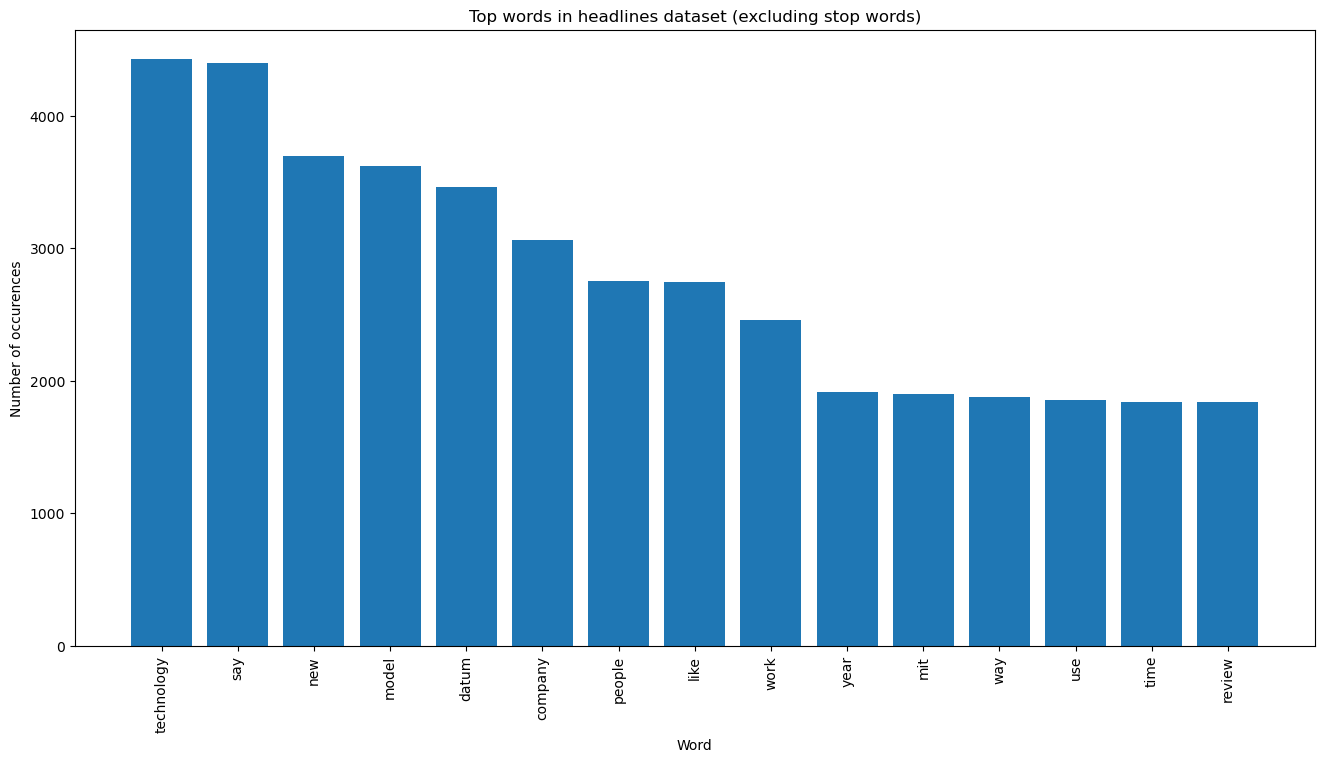

In [28]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [29]:
df.head()

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,141.0,522.0,p_16,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,495.0,334.0,p_19,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,616.0,861.0,p_0,useful robot need lazy useful robot need lazy ...
3,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,"['Marcus Holmström', 'The Gang', 'AI', 'France...",2,#0000ff,497.0,337.0,p_19,roblox launch generative build environment sna...
4,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,"['TEE', 'Microsoft Security', 'Insights', 'the...",2,#0000ff,632.0,319.0,p_7,integrate security code cloud sponsored integr...


### Save clean text

In [30]:
df.to_csv('Query_AI_text_clean.csv', index=False)

### Analysis

In [31]:
#df = pd.read_csv('Query_AI_text_clean.csv')

In [32]:
df.head(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,141.0,522.0,p_16,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,495.0,334.0,p_19,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,616.0,861.0,p_0,useful robot need lazy useful robot need lazy ...


### Temperature

In [33]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
307,"The Download: China’s AI chatbots go public, a...",https://www.technologyreview.com/2023/08/31/10...,2023,"The Download: China’s AI chatbots go public, a...","['US', 'Australia', 'X', 'Elon Musk', 'NASA', ...",1,#5500aa,420.0,711.0,p_12,download china chatbot public climate change a...
572,Machine-learning project takes aim at disinfor...,https://www.technologyreview.com/2021/05/03/10...,2021,Sponsored\nMachine-learning project takes aim ...,"['US', 'Insights', 'MIT Media Lab', 'the Busin...",-1,#ff0000,358.0,421.0,n_6,machine learn project take aim disinformation ...
146,The Download: how China plans to regulate AI,https://www.technologyreview.com/2024/04/09/10...,2024,The Download: how China plans to regulate AI\n...,"['US', 'The James Webb Space Telescope', 'New ...",2,#0000ff,374.0,296.0,p_9,download china plan regulate download china pl...


### Term Frequency

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["clean_text"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

df.head(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,141.0,522.0,p_16,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,495.0,334.0,p_19,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,616.0,861.0,p_0,useful robot need lazy useful robot need lazy ...


## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '317.90909090909076' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[site, ['y', 'x']] = [x,y]
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '681.8181818181822' has dtype incompatible with int64, please explicitl

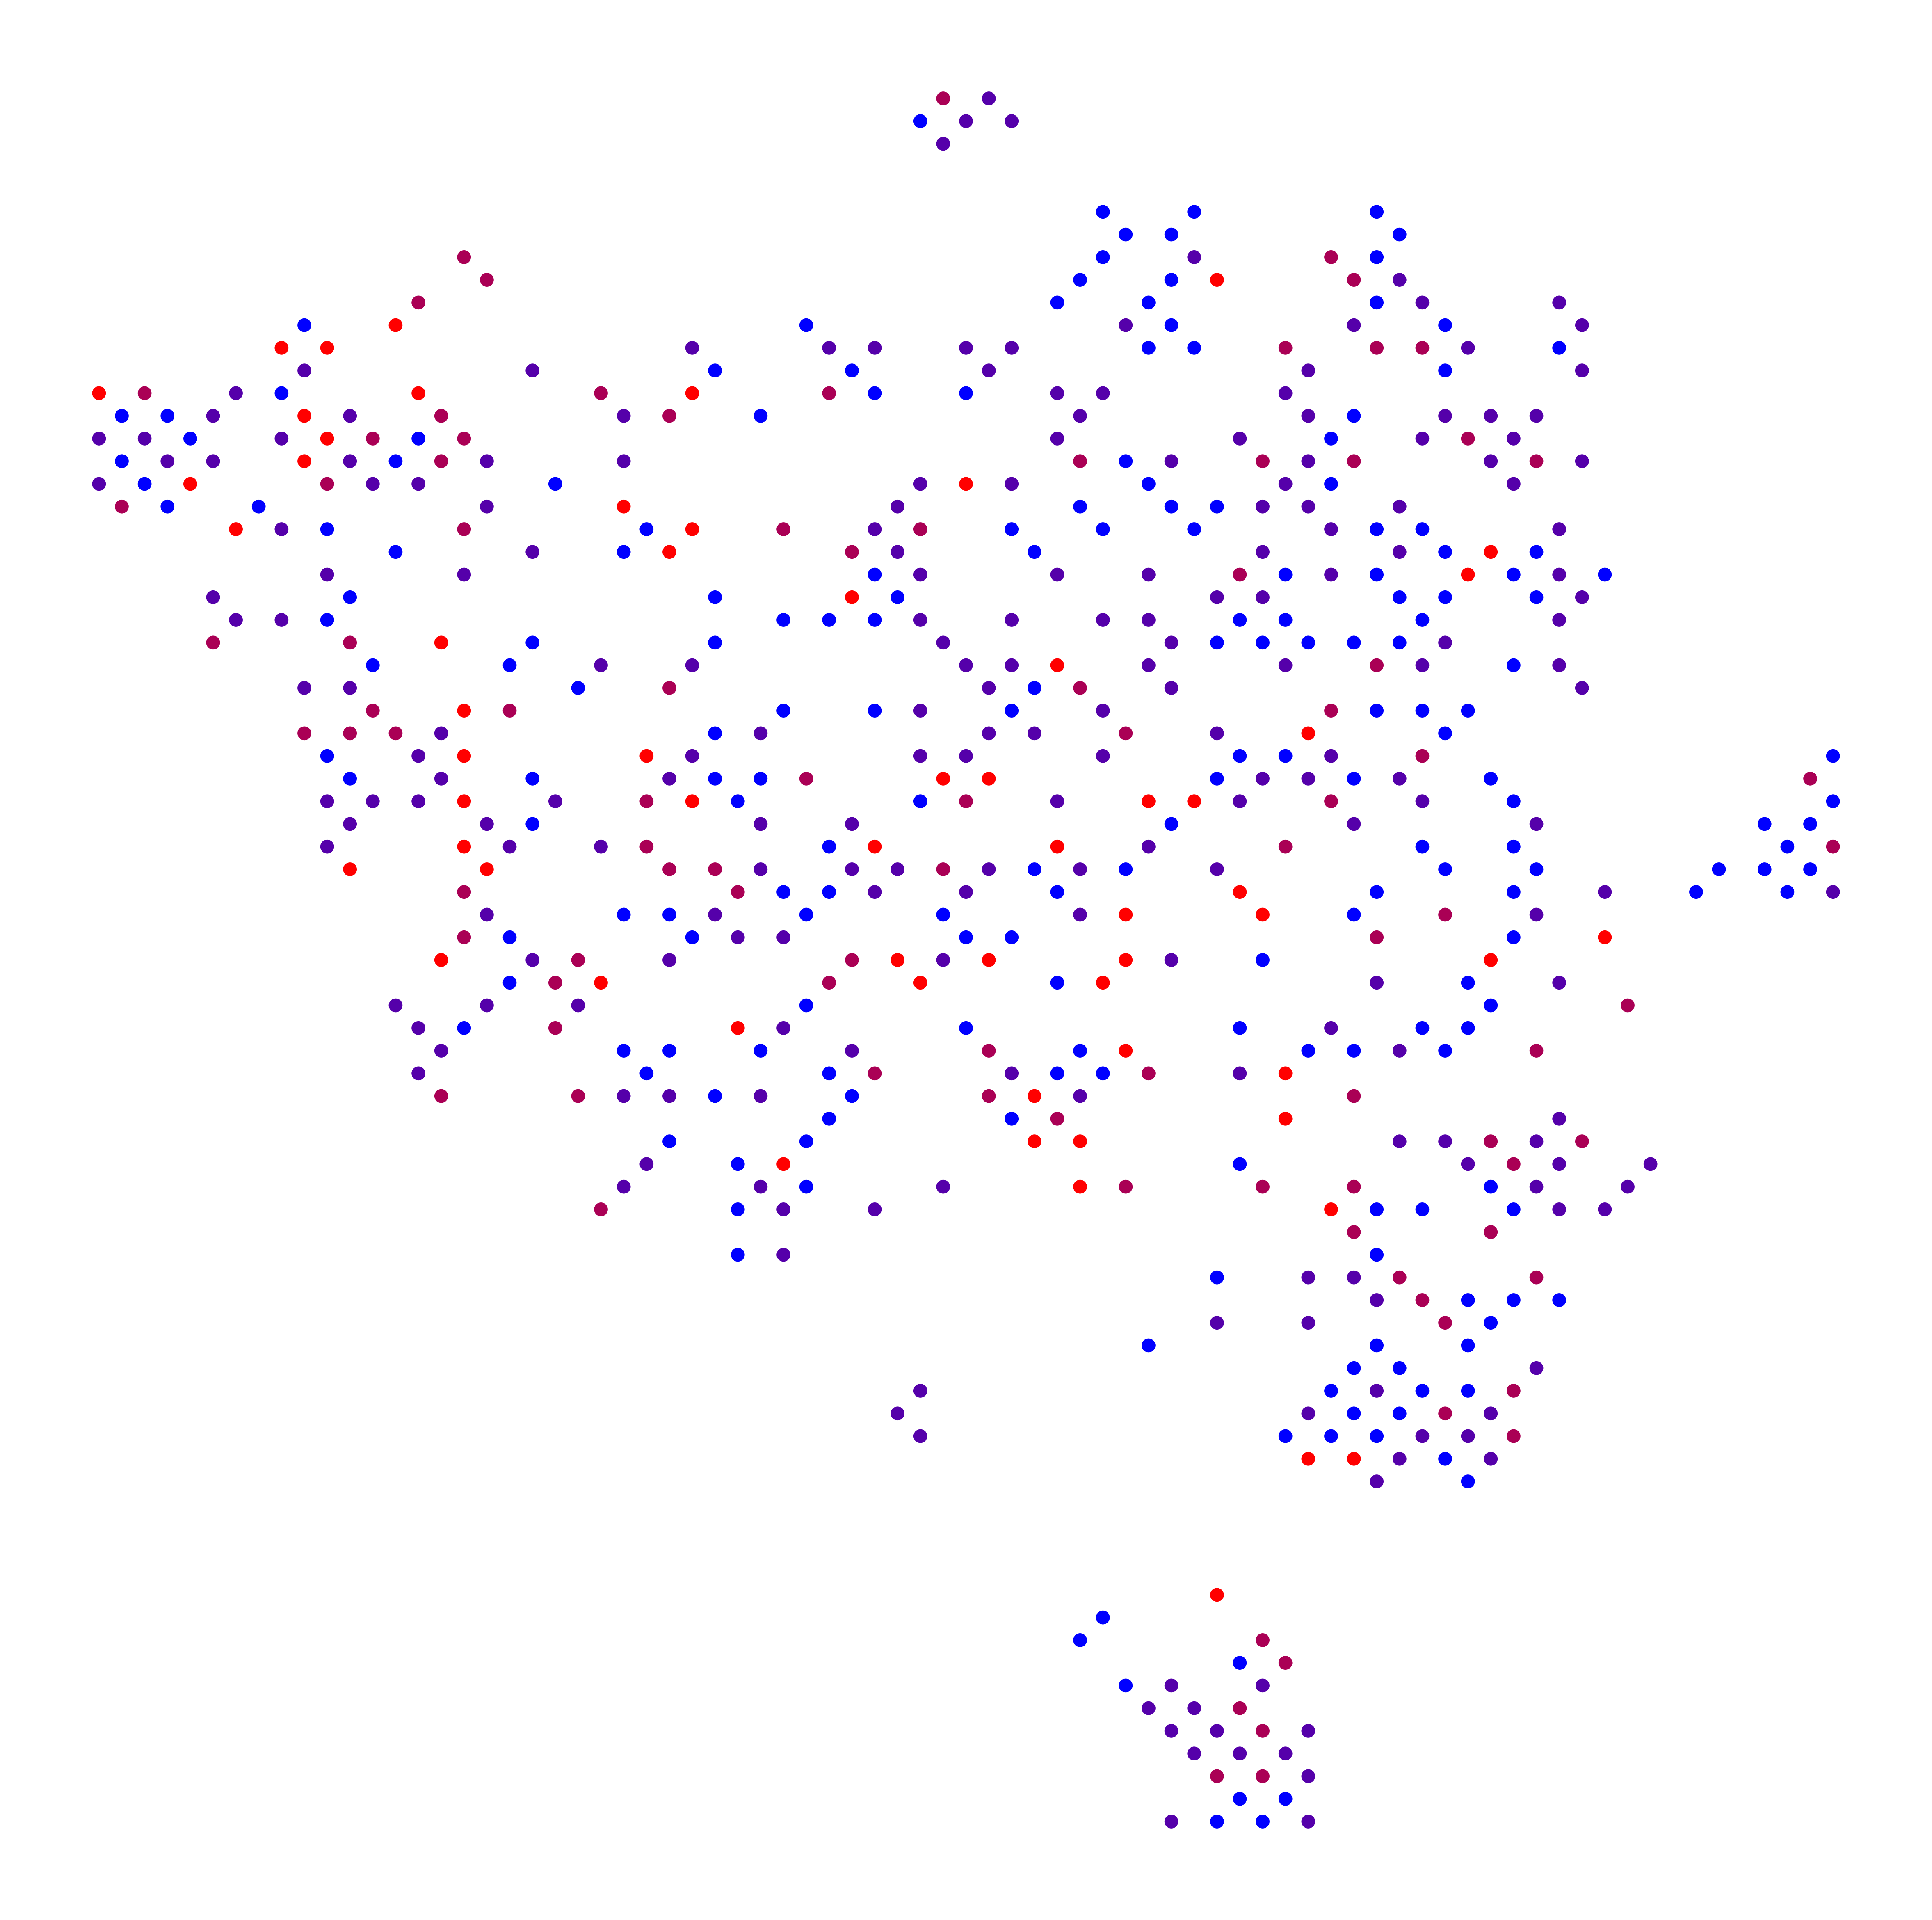

In [35]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=1,
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


## Clustering

In [36]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=3,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
95,"The Download: making surgery safer, and MDMA t...",https://www.technologyreview.com/2024/06/07/10...,2024,"The Download: making surgery safer, and MDMA t...","['Starliner', 'US', 'Keanu Reeves', 'Gary Numa...",2,#0000ff,712.987013,452.805195,p_24,download make surgery safe mdma therapy deal b...
508,From data and AI aspirations to sustainable bu...,https://www.technologyreview.com/2022/05/09/10...,2022,Sponsored\nFrom data and AI aspirations to sus...,"['Kyndryl', 'Business Process Services', 'DXC ...",0,#aa0055,245.454545,795.233766,n_3,datum aspiration sustainable business outcome ...
107,That viral video showing a head transplant is ...,https://www.technologyreview.com/2024/05/23/10...,2024,That viral video showing a head transplant is ...,"['Insilico Medicine', 'W. Tucker', 'US', 'TikT...",2,#0000ff,702.597403,380.168831,p_6,viral video show head transplant fake real som...


{'p_13', 'n_14', 'n_15', '-1', 'n_0', 'n_9', 'n_7', 'p_16', 'p_31', 'p_6', 'p_23', 'n_8', 'n_3', 'p_0', 'p_28', 'p_15', 'p_19', 'p_17', 'p_2', 'p_26', 'p_14', 'p_3', 'p_29', 'p_10', 'n_12', 'p_18', 'p_32', 'n_1', 'p_7', 'n_10', 'p_20', 'n_4', 'p_1', 'p_30', 'p_25', 'n_2', 'n_5', 'n_13', 'n_6', 'p_27', 'p_22', 'p_11', 'n_11', 'p_5', 'p_8', 'p_24', 'p_21', 'p_4', 'n_16', 'p_9', 'p_12'}


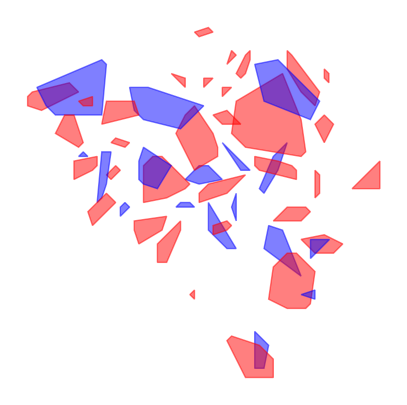

In [37]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [38]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
175,Watch this robot as it learns to stitch up wounds,https://www.technologyreview.com/2024/02/22/10...,2024,Watch this robot as it learns to stitch up wou...,"['Ken Goldberg', 'STAR', 'Super Mario', 'Genie...",2,#0000ff,837.662338,535.818182,p_4,watch robot learn stitch wound watch robot lea...
